In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mplfinance as mpf
import numpy as np
from scipy.signal import savgol_filter
from statsmodels.nonparametric.kernel_regression import KernelReg

data_10 = pd.read_csv('AAVEUSDT2022-07-10.csv')
data_11 = pd.read_csv('AAVEUSDT2022-07-11.csv')
data_12 = pd.read_csv('AAVEUSDT2022-07-12.csv')
data_x = data_10.append(data_11)
data = data_x.append(data_12)
data = data.drop(['tickDirection', 'trdMatchID'], axis=1)
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.tail()

C:\Users\daria\AppData\Local\Temp\ipykernel_10620\3779555121.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_x = data_10.append(data_11)
C:\Users\daria\AppData\Local\Temp\ipykernel_10620\3779555121.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data_x.append(data_12)


,timestamp,symbol,side,size,price,grossValue,homeNotional,foreignNotional
35505,2022-07-12 23:59:25,AAVEUSDT,Buy,7.00,68.35,4.784500e+10,7.00,478.450
35506,2022-07-12 23:59:28,AAVEUSDT,Buy,1.45,68.40,9.918000e+09,1.45,99.180
35507,2022-07-12 23:59:28,AAVEUSDT,Buy,7.00,68.40,4.788000e+10,7.00,478.800
35508,2022-07-12 23:59:28,AAVEUSDT,Buy,1.50,68.40,1.026000e+10,1.50,102.600
35509,2022-07-12 23:59:33,AAVEUSDT,Sell,0.01,68.40,6.840000e+07,0.01,0.684


In [3]:
def show_filtered_data():
    filter = (data['timestamp'] >= '2022-07-10 00:30:00') & (data['timestamp'] <= '2022-07-10 00:31:00')
    data.loc[filter]

In [4]:
def mpf_plot_create():
    mpf.plot(minutly_price,style='yahoo', type='candle', volume=True)

In [5]:
def show_candlestick_chart(inner_data):
    fig = go.Figure(data=[go.Candlestick(
                x=inner_data.index.to_list(),
                open=inner_data['Open'],
                high=inner_data['High'],
                low=inner_data['Low'],
                close=inner_data['Close'])])

    fig.show()

In [6]:
minutly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='min')]).agg(
        Open = ('price', 'first'),
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
minutly_price.tail()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-12 23:55:00,68.35,68.35,68.30,68.30,42.38
2022-07-12 23:56:00,68.30,68.50,68.30,68.30,276.29
2022-07-12 23:57:00,68.25,68.30,68.25,68.25,348.39
2022-07-12 23:58:00,68.25,68.30,68.20,68.25,153.49
2022-07-12 23:59:00,68.30,68.40,68.30,68.40,83.51


In [7]:
rolling = minutly_price.rolling(window=100).mean()
rolling.tail()

,Open,High,Low,Close,Volume
timestamp,,,,,
2022-07-12 23:55:00,NaN,NaN,NaN,NaN,161.8313
2022-07-12 23:56:00,NaN,NaN,NaN,NaN,161.5257
2022-07-12 23:57:00,NaN,NaN,NaN,NaN,164.3973
2022-07-12 23:58:00,NaN,NaN,NaN,NaN,163.4514
2022-07-12 23:59:00,NaN,NaN,NaN,NaN,161.5865


In [8]:
show_candlestick_chart(minutly_price)

0.19951338199513388 65.8
82.2 65.8
[3478 3479 3480 3486]


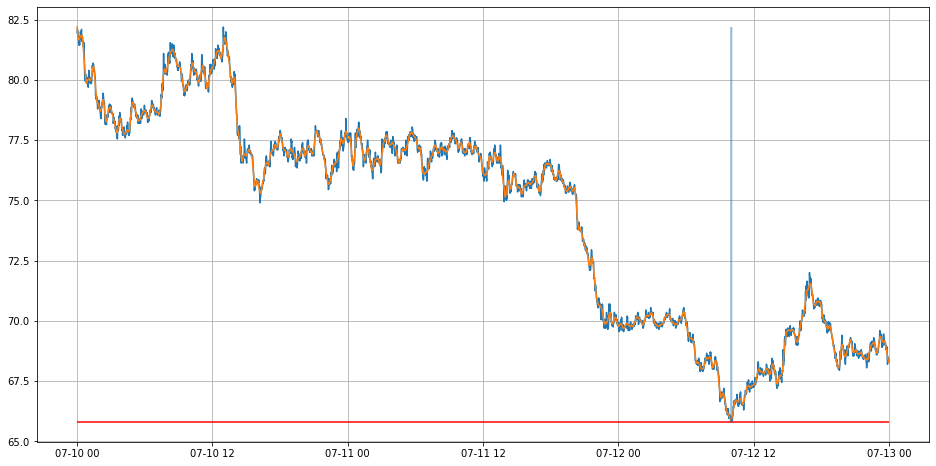

In [18]:
plt.figure(figsize=(16, 8))
plt.grid()

new_prices = minutly_price[:]
new_prices = new_prices.fillna(method="ffill")
#print(new_prices.isnull().sum())
p = np.array(new_prices['High'])
t = np.array(new_prices.index)
p_smoth = savgol_filter(p, 30, 3)

plt.plot(t, p)
plt.plot(t, p_smoth)

p_rolling = np.array(rolling['High'])
#plt.plot(t, p_rolling)

dpdt = np.diff(p)/1

#plt.plot(t[1:], dpdt+82)

maxi = []
val_max = []
val_min = []
indexes_max = []
indexes_min = []

for i in range(1, len(p)-1):
    if p[i] > p[i-1]:
        if p[i] > p[i+1]:
            val_max.append(p[i])
            indexes_max.append(i)

for i in range(0, len(p)-1):
    if p[i] < p[i-1]:
        if p[i] < p[i+1]:
            val_min.append(p[i])
            indexes_min.append(i)

a = np.where(dpdt == 0)

"""
plt.vlines(t[indexes_max], p.min(), p.max())
plt.vlines(t[indexes_min], p.min(), p.max(), color = 'r')
plt.vlines(t[a[0]], p.min(), p.max(), color = 'g')
"""

min_abs = np.min(val_min)

th = 0.005
diff_percent = (np.max(p) - np.min(p))/np.max(p)
print(diff_percent, min_abs)

b = np.where(p < diff_percent * th * np.mean(p) + min_abs)

print(np.max(p), np.min(p)) 
#plt.vlines(t[146], p.min(), p.max())
#plt.vlines(t[b], p.min(), p.max(), alpha=0.2)

if len(b[0]) >= 2:
    plt.hlines(min_abs, t.min(), t.max(), color = 'r')
    plt.vlines(t[b], p.min(), p.max(), alpha=0.2)
else:
    print("no support")

print(b[0])

For smooth values

0.0839020026305248 75.22145833333383
82.11071146245062 75.22145833333383
[48 51]


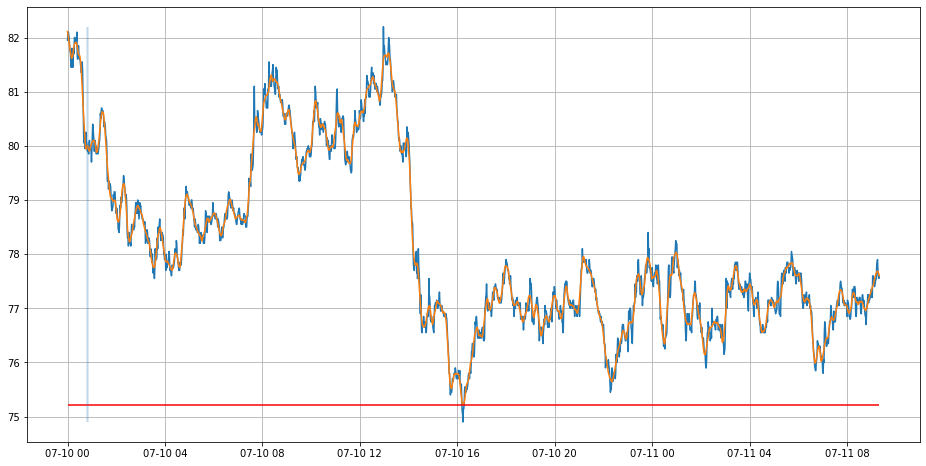

In [35]:
plt.figure(figsize=(16, 8))
plt.grid()

new_prices = minutly_price[:2000]
new_prices = new_prices.fillna(method="ffill")
#print(new_prices.isnull().sum())
p = np.array(new_prices['High'])
t = np.array(new_prices.index)
p_smooth = savgol_filter(p, 20, 3)

plt.plot(t, p)
plt.plot(t, p_smooth)

val_max = []
val_min = []
indexes_max = []
indexes_min = []

for i in range(1, len(p_smooth)-1):
    if p_smooth[i] > p_smooth[i-1]:
        if p_smooth[i] > p_smooth[i+1]:
            val_max.append(p_smooth[i])
            indexes_max.append(i)

for i in range(0, len(p_smooth)-1):
    if p_smooth[i] < p_smooth[i-1]:
        if p_smooth[i] < p_smooth[i+1]:
            val_min.append(p_smooth[i])
            indexes_min.append(i)

a = np.where(dpdt == 0)

min_abs = np.min(val_min)

th = 0.05
diff_percent = (np.max(p_smooth) - np.min(p_smooth))/np.max(p_smooth)

print(diff_percent, min_abs)

b = np.where(val_min < diff_percent * th * np.mean(p_smooth) + min_abs)

print(np.max(p_smooth), np.min(p_smooth)) 

if len(b[0]) >= 2:
    plt.hlines(min_abs, t.min(), t.max(), color = 'r')
    plt.vlines(t[b], p.min(), p.max(), alpha=0.2)
else:
    print("no support")

print(b[0])

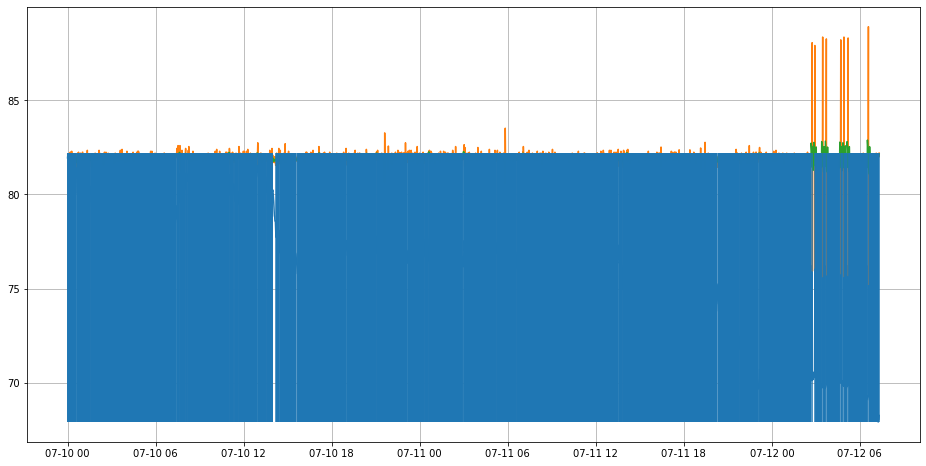

In [10]:
limit = 0.1
plt.figure(figsize=(16, 8))
plt.grid()

dpdt = np.diff(p)/1

dpdt_smoth = savgol_filter(dpdt, 10, 3)

b = np.where((dpdt_smoth <= limit) & (dpdt_smoth >= -limit))
#a = np.where(b[0] > -0.001)

#print(dpdt_smoth)
#print(b)
#print(dpdt_smoth[b[0]])

plt.plot(t, p)
plt.plot(t[1:], dpdt+82)
plt.plot(t[1:], dpdt_smoth+82)
plt.vlines(t[b[0]], p.min(), p.max())

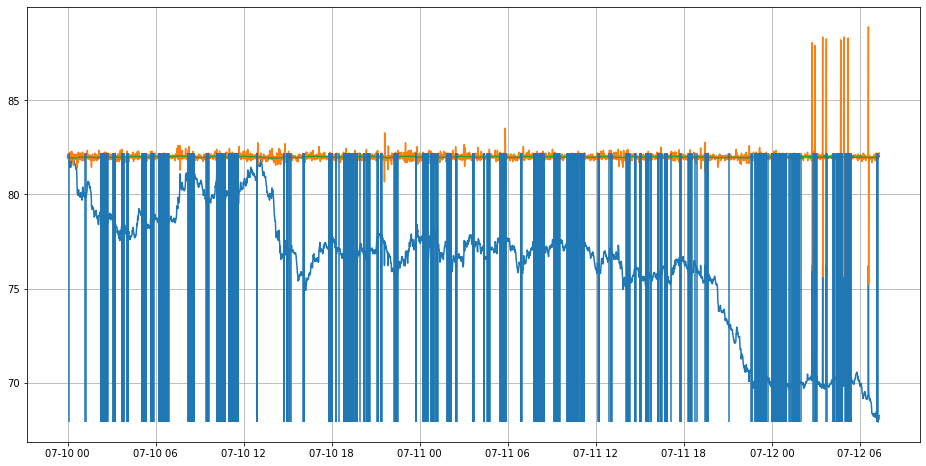

In [11]:
limit = 0.005
plt.figure(figsize=(16, 8))
plt.grid()

dpdt = np.diff(p)/1

dpdt_smoth = savgol_filter(dpdt, 100, 3)

b = np.where((dpdt_smoth <= limit) & (dpdt_smoth >= -limit))
#a = np.where(b[0] > -0.001)

#print(dpdt_smoth)
#print(b)
#print(dpdt_smoth[b[0]])

plt.plot(t, p)
plt.plot(t[1:], dpdt+82)
plt.plot(t[1:], dpdt_smoth+82)
plt.vlines(t[b[0]], p.min(), p.max())

[ 0.15  0.15  0.   -0.05 -0.05 -0.15 -0.1   0.   -0.2  -0.1 ]
[ 0.15  0.   -0.05 -0.05 -0.15 -0.1   0.   -0.2  -0.1   0.1 ]
[ 8.52096171e-15  1.50000000e-01  5.00000000e-02  0.00000000e+00
  1.00000000e-01 -5.00000000e-02 -1.00000000e-01  2.00000000e-01
 -1.00000000e-01 -2.00000000e-01]


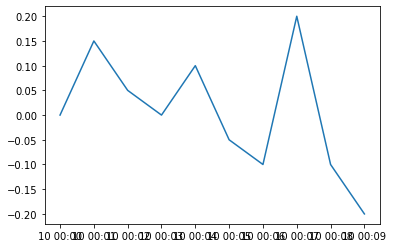

In [12]:
dpdt = np.diff(p)/1
dpdt_right_shift = [0.15]
b = np.append(dpdt_right_shift, dpdt[:9], axis=None)

print(b)
print(dpdt[:10])
a = b - dpdt[:10]
print(a)
plt.plot(t[:10], a)

In [13]:
hourly_price = data.groupby([pd.Grouper(
    key='timestamp', freq='H')]).agg(
        High = ('price', 'max'),
        Low = ('price', 'min'),
        Open = ('price', 'first'),
        Close = ('price', 'last'),
        Volume = ('size', 'sum'), ).round(2)
hourly_price.head(24)

,High,Low,Open,Close,Volume
timestamp,,,,,
2022-07-10 00:00:00,82.10,79.45,81.80,79.60,43072.77
2022-07-10 01:00:00,80.70,78.55,79.65,78.65,43319.46
2022-07-10 02:00:00,79.45,77.15,78.65,78.85,31518.30
2022-07-10 03:00:00,78.90,77.45,78.80,77.85,23232.52
2022-07-10 04:00:00,79.25,77.35,77.80,78.90,26194.27
2022-07-10 05:00:00,79.00,78.05,78.85,78.70,15846.35
2022-07-10 06:00:00,79.15,78.15,78.70,78.60,10415.79
2022-07-10 07:00:00,81.10,78.40,78.60,80.25,33342.11
2022-07-10 08:00:00,81.55,80.05,80.20,80.50,29152.15


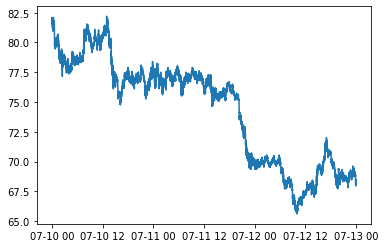

In [14]:
plt.plot(data.timestamp, data.price)